In [1]:
# Download npz data for training LSTM
# Download sample dataset for evaluation
!gdown 1W4fYBpk68TYbGvLc3wu2zH2Zwo2nxJa6 -O pose_tensor_npz.zip
!gdown 1Ie1g9ajkay5m8P7rMaO_i2Zr9YFc3wEd -O Dataset_sample.zip
!unzip pose_tensor_npz.zip
!unzip Dataset_sample.zip

Downloading...
From (original): https://drive.google.com/uc?id=1W4fYBpk68TYbGvLc3wu2zH2Zwo2nxJa6
From (redirected): https://drive.google.com/uc?id=1W4fYBpk68TYbGvLc3wu2zH2Zwo2nxJa6&confirm=t&uuid=08fd907f-c664-4d41-a6fc-e2ef30096649
To: /content/pose_tensor_npz.zip
100% 18.6M/18.6M [00:00<00:00, 34.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Ie1g9ajkay5m8P7rMaO_i2Zr9YFc3wEd
From (redirected): https://drive.google.com/uc?id=1Ie1g9ajkay5m8P7rMaO_i2Zr9YFc3wEd&confirm=t&uuid=6f58e33f-ed78-4bd3-9dfe-1ec9e27f547e
To: /content/Dataset_sample.zip
100% 403M/403M [00:06<00:00, 63.5MB/s]
Archive:  pose_tensor_npz.zip
   creating: pose_tensor_npz/N/
   creating: pose_tensor_npz/N/Training/
   creating: pose_tensor_npz/N/Training/00005_H_A_N_C1/
  inflating: pose_tensor_npz/N/Training/00005_H_A_N_C1/00005_H_A_N_C1.npz  
   creating: pose_tensor_npz/N/Training/00005_H_A_N_C2/
  inflating: pose_tensor_npz/N/Training/00005_H_A_N_C2/00005_H_A_N_C2.npz  
   creating: pose_tens

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

def load_npz_frames(root_dir, split):
    seqs, labs, lengths = [], [], []
    total_files = 0
    valid_files = 0
    skipped_missing_keys = 0
    skipped_shape_mismatch = 0
    skipped_low_visibility = 0  # 새 항목 추가

    for label_dir in ['Y', 'N']:
        base = os.path.join(root_dir, label_dir, split)
        for subdir, _, files in os.walk(base):
            for fn in files:
                if not fn.endswith('.npz'):
                    continue
                full_path = os.path.join(subdir, fn)
                total_files += 1
                print(f"[INFO] 검사 중: {full_path}")
                try:
                    data = np.load(full_path, allow_pickle=True)
                    keys = data.files
                    print(f"       포함된 키: {keys}")

                    if not all(k in keys for k in ['pose', 'label', 'confidence']):
                        print("       [SKIP] 'pose', 'label', 'confidence' 중 일부가 없습니다.")
                        skipped_missing_keys += 1
                        continue

                    p = data['pose']
                    c = data['confidence']
                    l = data['label']

                    print(f"       라벨 종류: {np.unique(l)}")

                    if (
                        p.ndim == 3 and p.shape[1:] == (17, 2) and
                        c.shape == (p.shape[0], 17) and
                        l.shape == (p.shape[0],)
                    ):
                        # confidence 값이 0이 아닌 skeleton만 학습에 사용
                        frame_visibility = (c > 0).sum(axis=1) >= 5  # skeleton이 최소 5개 이상 감지된 프레임만 학습에 사용
                        visible_frame_count = frame_visibility.sum()

                        if visible_frame_count < 33:
                            print(f"       [SKIP] 감지된 프레임 수 부족: {visible_frame_count}/50")
                            skipped_low_visibility += 1
                            continue

                        valid_files += 1
                        T = p.shape[0]
                        for t in range(1, T):
                            zero_joints = np.where((p[t,:,0] == 0) & (p[t,:,1] == 0))[0]
                            if zero_joints.size > 0:
                                p[t, zero_joints] = p[t-1, zero_joints]

                        pc = np.concatenate([p, c[:,:,None]], axis=-1)
                        pc_flat = pc.reshape(T, -1)
                        seqs.append(torch.tensor(pc_flat, dtype=torch.float32))
                        labs.append(torch.tensor(l, dtype=torch.float32))
                        lengths.append(T)
                    else:
                        print(f"       [SKIP] shape mismatch: pose={p.shape}, confidence={c.shape}, label={l.shape}")
                        skipped_shape_mismatch += 1
                except Exception as e:
                    print(f"       [ERROR] {e}")

    print("\n====== 로딩 요약 ======")
    print(f"총 .npz 파일 수:           {total_files}")
    print(f"유효한 시퀀스:             {valid_files}")
    print(f"키 누락으로 스킵된 파일:   {skipped_missing_keys}")
    print(f"shape mismatch로 스킵:     {skipped_shape_mismatch}")
    print(f"프레임 감지 부족으로 스킵: {skipped_low_visibility}")
    print("========================\n")

    return seqs, labs, lengths

class FallFrameDataset(torch.utils.data.Dataset):
    def __init__(self, seqs, labs, lengths):
        self.seqs, self.labs, self.lengths = seqs, labs, lengths
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, i):
        return self.seqs[i], self.labs[i], self.lengths[i]

def collate_fn(batch):
    seqs, labs, lens = zip(*batch)
    X = pad_sequence(seqs, batch_first=True)
    Y = pad_sequence(labs, batch_first=True)
    L = torch.tensor(lens, dtype=torch.long)
    return X.to(device), Y.to(device), L.to(device)

class FrameLSTM(nn.Module):
    def __init__(self, input_size=51, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True,
                            bidirectional=True, num_layers=2, dropout=0.3)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        out_packed, _ = self.lstm(packed)
        out_unpacked, _ = pad_packed_sequence(out_packed, batch_first=True)
        return self.fc(out_unpacked).squeeze(-1)

# Load data
root = "/content/pose_tensor_npz"
train_seqs, train_labs, train_lens = load_npz_frames(root, 'Training')
val_seqs, val_labs, val_lens = load_npz_frames(root, 'Validation')

train_loader = DataLoader(FallFrameDataset(train_seqs, train_labs, train_lens), batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(FallFrameDataset(val_seqs, val_labs, val_lens), batch_size=16, shuffle=False, collate_fn=collate_fn)

# Model setup
model = FrameLSTM(input_size=51).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

all_train = torch.cat(train_labs)
pos = all_train.sum()
neg = all_train.numel() - pos
pos_weight_val = (neg / pos).item()
print(f"[INFO] pos_weight: {pos_weight_val:.4f}")
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight_val).to(device))

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
THRESHOLD = 0.75
patience = 5
no_improve = 0
best_val_f1 = 0
train_losses, train_f1s, val_f1s = [], [], []


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
       포함된 키: ['pose', 'confidence', 'label']
       라벨 종류: [0 1]
[INFO] 검사 중: /content/pose_tensor_npz/Y/Training/02221_H_A_FY_C6/02221_H_A_FY_C6.npz
       포함된 키: ['pose', 'confidence', 'label']
       라벨 종류: [0 1]
[INFO] 검사 중: /content/pose_tensor_npz/Y/Training/00079_H_A_SY_C6/00079_H_A_SY_C6.npz
       포함된 키: ['pose', 'confidence', 'label']
       라벨 종류: [0 1]
[INFO] 검사 중: /content/pose_tensor_npz/Y/Training/02430_H_A_FY_C2/02430_H_A_FY_C2.npz
       포함된 키: ['pose', 'confidence', 'label']
       라벨 종류: [0 1]
[INFO] 검사 중: /content/pose_tensor_npz/Y/Training/01741_Y_E_BY_C2/01741_Y_E_BY_C2.npz
       포함된 키: ['pose', 'confidence', 'label']
       라벨 종류: [0 1]
[INFO] 검사 중: /content/pose_tensor_npz/Y/Training/01925_Y_E_FY_C1/01925_Y_E_FY_C1.npz
       포함된 키: ['pose', 'confidence', 'label']
       라벨 종류: [0 1]
[INFO] 검사 중: /content/pose_tensor_npz/Y/Training/00053_H_A_SY_C8/00053_H_A_SY_C8.npz
       포함된 키: ['pose', 'confidence', 'label']
       라벨 종류

Epoch  1 | Loss: 1.1979 | Train F1: 0.193 | Val F1: 0.036 | Evt Rec: 0.050 | Delay: 4.13
Epoch  2 | Loss: 0.9147 | Train F1: 0.455 | Val F1: 0.263 | Evt Rec: 0.907 | Delay: 1.16
Epoch  3 | Loss: 0.6946 | Train F1: 0.566 | Val F1: 0.496 | Evt Rec: 0.963 | Delay: 0.72
Epoch  4 | Loss: 0.5956 | Train F1: 0.614 | Val F1: 0.586 | Evt Rec: 0.957 | Delay: 0.91
Epoch  5 | Loss: 0.5213 | Train F1: 0.632 | Val F1: 0.667 | Evt Rec: 0.972 | Delay: 0.34
Epoch  6 | Loss: 0.4314 | Train F1: 0.691 | Val F1: 0.618 | Evt Rec: 0.993 | Delay: 0.18
Epoch  7 | Loss: 0.4061 | Train F1: 0.711 | Val F1: 0.700 | Evt Rec: 0.972 | Delay: 0.11
Epoch  8 | Loss: 0.3490 | Train F1: 0.737 | Val F1: 0.688 | Evt Rec: 0.989 | Delay: 0.56
Epoch  9 | Loss: 0.3473 | Train F1: 0.741 | Val F1: 0.698 | Evt Rec: 1.000 | Delay: 0.15
Epoch 10 | Loss: 0.3425 | Train F1: 0.740 | Val F1: 0.735 | Evt Rec: 0.998 | Delay: 0.03
Epoch 11 | Loss: 0.3195 | Train F1: 0.759 | Val F1: 0.741 | Evt Rec: 0.998 | Delay: 0.13
Epoch 12 | Loss: 0.30

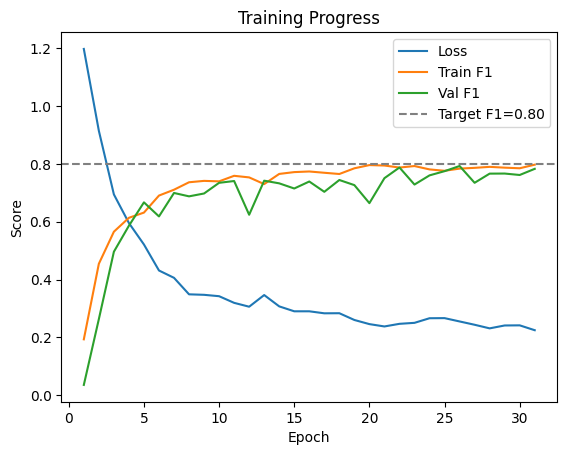

In [4]:
# Training loop
for epoch in range(1, 51):
    model.train()
    epoch_loss = 0.0
    t_preds, t_trues = [], []

    for X, Y, L in train_loader:
        logits = model(X, L)
        mask = torch.arange(logits.size(1), device=logits.device)[None, :] < L[:, None]
        loss = criterion(logits[mask], Y[mask])
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(logits[mask]) > THRESHOLD)
        t_preds += preds.int().tolist()
        t_trues += Y[mask].int().tolist()

    avg_loss = epoch_loss / len(train_loader)
    tr_f1 = f1_score(t_trues, t_preds)
    train_losses.append(avg_loss)
    train_f1s.append(tr_f1)

    # Validation
    model.eval()
    preds, trues, delays = [], [], []
    total_ev = detected_ev = 0
    with torch.no_grad():
        for X, Y, L in val_loader:
            logits = model(X, L)
            probs = torch.sigmoid(logits)
            for b in range(X.size(0)):
                T = L[b].item()
                true_seq = Y[b, :T].int().tolist()
                pred_seq = (probs[b, :T] > THRESHOLD).tolist()
                trues += true_seq
                preds += list(map(int, pred_seq))
                if any(true_seq):
                    total_ev += 1
                    first_t = true_seq.index(1)
                    if any(pred_seq):
                        detected_ev += 1
                        first_p = pred_seq.index(True)
                        delays.append(max(0, first_p - first_t))
    val_f1 = f1_score(trues, preds)
    evt_rec = detected_ev / total_ev if total_ev else 0
    avg_delay = sum(delays)/len(delays) if delays else 0
    val_f1s.append(val_f1)

    print(f"Epoch {epoch:2d} | Loss: {avg_loss:.4f} | Train F1: {tr_f1:.3f} | Val F1: {val_f1:.3f} | Evt Rec: {evt_rec:.3f} | Delay: {avg_delay:.2f}")
    scheduler.step(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping.")
            break

# save best_model.pth
save_path = "/content/best_model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)

# 시각화
plt.plot(range(1, len(train_f1s)+1), train_losses, label='Loss')
plt.plot(range(1, len(train_f1s)+1), train_f1s, label='Train F1')
plt.plot(range(1, len(train_f1s)+1), val_f1s, label='Val F1')
plt.axhline(0.80, color='gray', linestyle='--', label='Target F1=0.80')
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend(); plt.title("Training Progress"); plt.show()

Average Precision (AP): 0.8681
Best threshold: 0.903, Max Frame-level F1: 0.8026


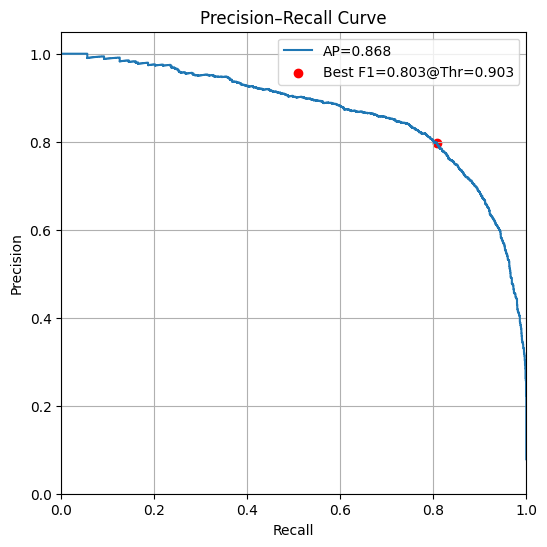


[최종 평가 - Best Threshold 기준]
Best threshold = 0.9031945466995239
Frame-level F1: 0.8023
Event Recall:   0.9675
Average Delay:  0.38 frame(s)


In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

# 1) 모델 로드 (CPU)
model = FrameLSTM(input_size=51, hidden_size=64)
model.load_state_dict(torch.load('/content/best_model.pth', map_location='cpu'))
model.eval()
device = torch.device("cpu")

# 2) 모든 validation 데이터에 대해 확률 예측 수집
all_probs, all_labels = [], []

with torch.no_grad():
    for X, Y, L in val_loader:
        X, Y, L = X.to(device), Y.to(device), L.to(device)
        logits = model(X, L)
        probs = torch.sigmoid(logits)
        mask = torch.arange(probs.size(1))[None, :] < L[:, None]
        all_probs += probs[mask].cpu().numpy().tolist()
        all_labels += Y[mask].cpu().numpy().tolist()

# numpy 변환
all_probs = np.array(all_probs)
all_labels = np.array(all_labels, dtype=int)

# 3) PR 곡선 및 Best Threshold 계산
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
ap = average_precision_score(all_labels, all_probs)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Average Precision (AP): {ap:.4f}")
print(f"Best threshold: {best_thresh:.3f}, Max Frame-level F1: {best_f1:.4f}")

# 4) PR 곡선 시각화
plt.figure(figsize=(6,6))
plt.step(recall, precision, where='post', label=f'AP={ap:.3f}')
plt.scatter(recall[best_idx], precision[best_idx],
            color='red',
            label=f'Best F1={best_f1:.3f}@Thr={best_thresh:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.legend()
plt.grid(True)
plt.show()

# 5) best threshold로 다시 평가 (Frame F1, Event Recall, Delay)
model.eval()
trues, preds, delays = [], [], []
total_ev = detected_ev = 0

with torch.no_grad():
    for X, Y, L in val_loader:
        X, Y, L = X.to(device), Y.to(device), L.to(device)
        logits = model(X, L)
        probs = torch.sigmoid(logits)
        for b in range(X.size(0)):
            T = L[b].item()
            true_seq = Y[b, :T].int().tolist()
            pred_seq = (probs[b, :T] > best_thresh).tolist()
            trues += true_seq
            preds += list(map(int, pred_seq))

            if any(true_seq):
                total_ev += 1
                first_t = true_seq.index(1)
                if any(pred_seq):
                    detected_ev += 1
                    first_p = pred_seq.index(True)
                    delays.append(max(0, first_p - first_t))

frame_f1 = f1_score(trues, preds)
event_recall = detected_ev / total_ev if total_ev else 0
avg_delay = sum(delays) / len(delays) if delays else 0

print(f"\n[최종 평가 - Best Threshold 기준]")
print("Best threshold =", best_thresh)
print(f"Frame-level F1: {frame_f1:.4f}")
print(f"Event Recall:   {event_recall:.4f}")
print(f"Average Delay:  {avg_delay:.2f} frame(s)")


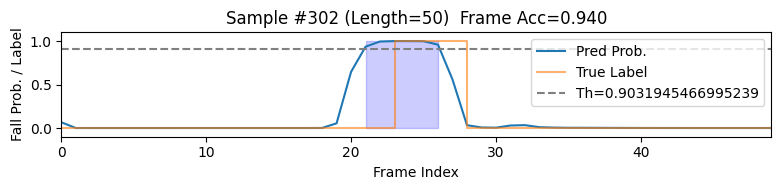

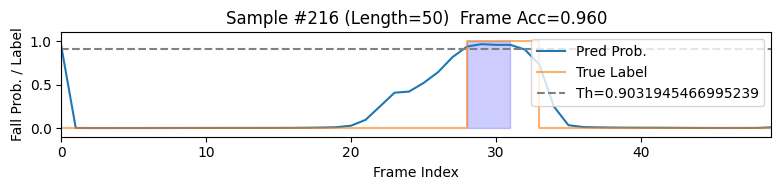

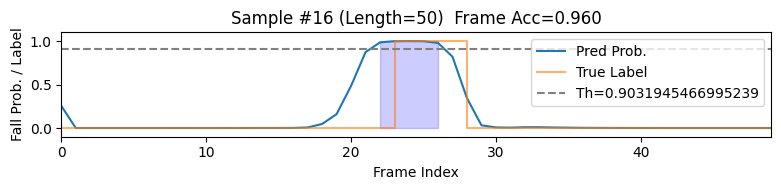

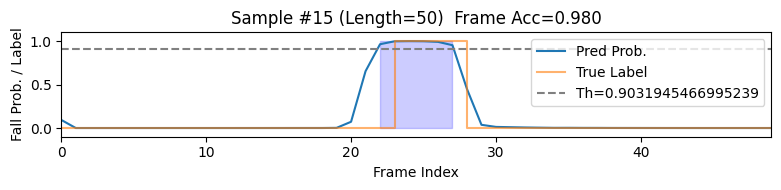

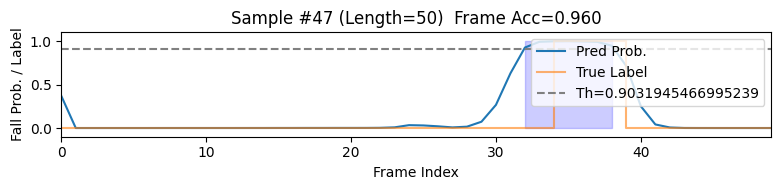

In [9]:
import random
import matplotlib.pyplot as plt
import torch
import numpy as np

# Threshold 및 샘플 개수 설정
THRESHOLD   = best_thresh
NUM_SAMPLES = 5

# LSTM 모델 로드
model = FrameLSTM(input_size=51, hidden_size=64)
model.load_state_dict(torch.load('/content/best_model.pth', map_location='cpu'))
model.eval()

# 검증 데이터셋에서 랜덤 인덱스 추출 및 시각화
indices = random.sample(range(len(val_seqs)), NUM_SAMPLES)

with torch.no_grad():
    for idx in indices:
        seq   = val_seqs[idx]     # (T, 51)
        label = val_labs[idx]     # (T,)
        L     = val_lens[idx]     # int

        X       = seq.unsqueeze(0)            # (1, T, 51)
        lengths = torch.tensor([L])           # (1,)

        logits = model(X, lengths)            # (1, T_max)
        probs  = torch.sigmoid(logits)[0]     # (T_max,)
        preds  = (probs > THRESHOLD).int().tolist()
        trues  = label.int().tolist()

        correct = sum(p == t for p, t in zip(preds[:L], trues[:L]))
        frame_acc = correct / L

        T = L
        plt.figure(figsize=(8, 2))
        plt.plot(probs[:T].cpu(), label='Pred Prob.')
        plt.fill_between(range(L), 0, 1, where=np.array(preds[:L])==1, color='blue', alpha=0.2, step='post')
        plt.plot(trues[:T], label='True Label', alpha=0.6, drawstyle='steps-post')
        plt.axhline(THRESHOLD, color='gray', linestyle='--', label=f'Th={THRESHOLD}')
        plt.ylim(-0.1, 1.1)
        plt.xlim(0, T-1)
        plt.xlabel('Frame Index')
        plt.ylabel('Fall Prob. / Label')
        plt.title(f'Sample #{idx} (Length={T})  Frame Acc={frame_acc:.3f}')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
